
=== Daily Summary (rows, avg price, avg_ofi) ===
shape: (4, 5)
┌────────┬────────────┬──────────┬─────────────────┬───────────┐
│ ticker ┆ date       ┆ num_rows ┆ avg_trade_price ┆ avg_ofi   │
│ ---    ┆ ---        ┆ ---      ┆ ---             ┆ ---       │
│ str    ┆ str        ┆ i64      ┆ f64             ┆ f64       │
╞════════╪════════════╪══════════╪═════════════════╪═══════════╡
│ CTL    ┆ 2010-05-03 ┆ 21869    ┆ 34.490966       ┆ -0.005722 │
│ CTL    ┆ 2010-05-06 ┆ 35439    ┆ 33.559592       ┆ -0.008935 │
│ XOM    ┆ 2010-05-03 ┆ 125215   ┆ 67.760781       ┆ -0.004808 │
│ XOM    ┆ 2010-05-06 ┆ 290587   ┆ 64.457964       ┆ -0.005815 │
└────────┴────────────┴──────────┴─────────────────┴───────────┘


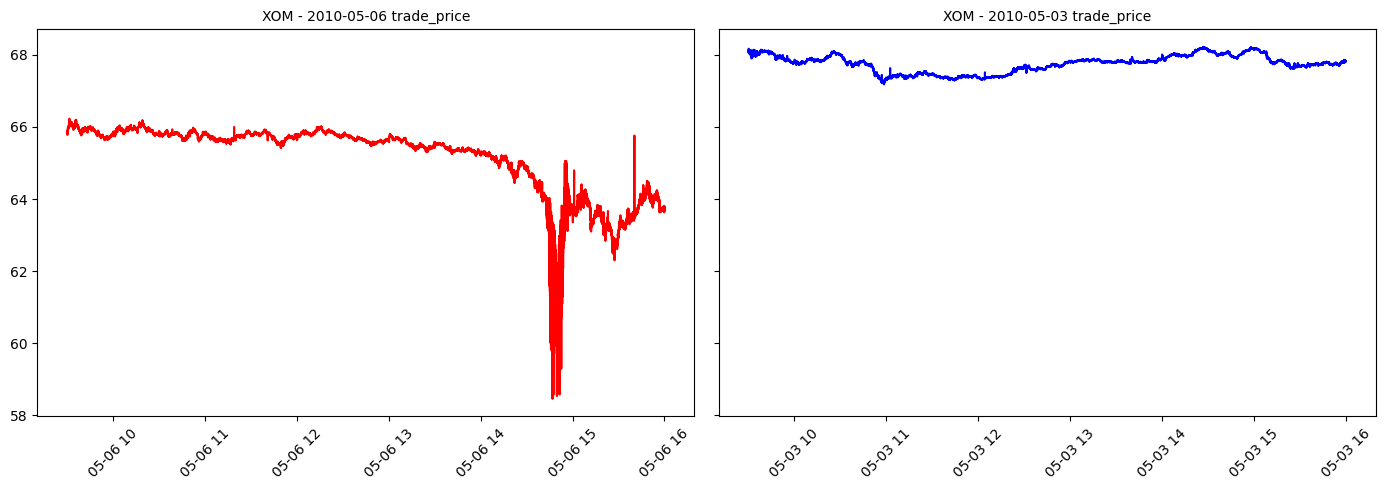

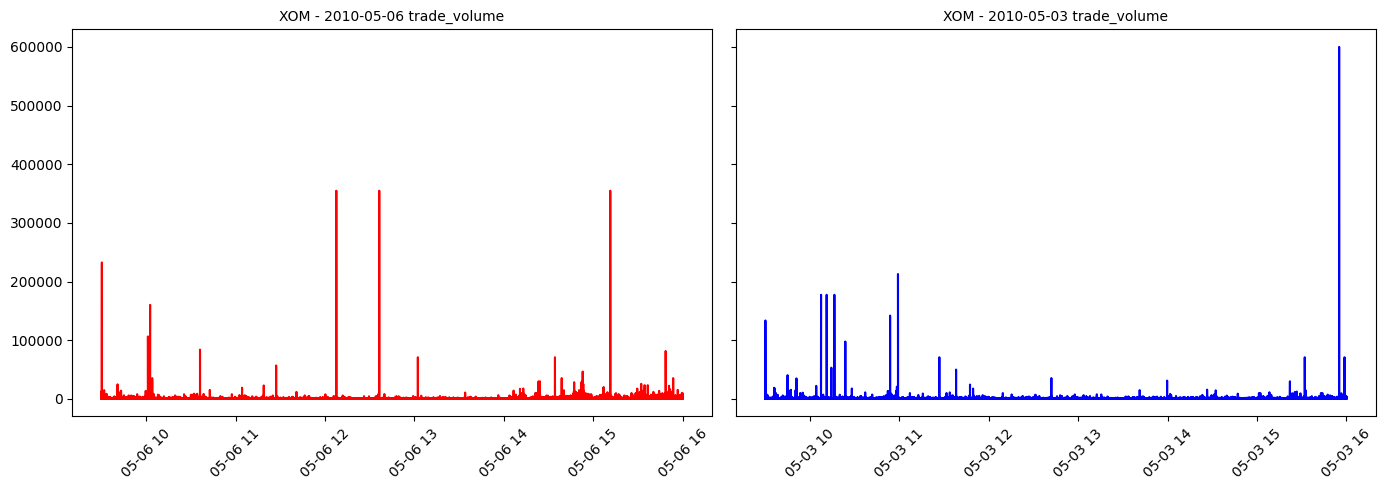

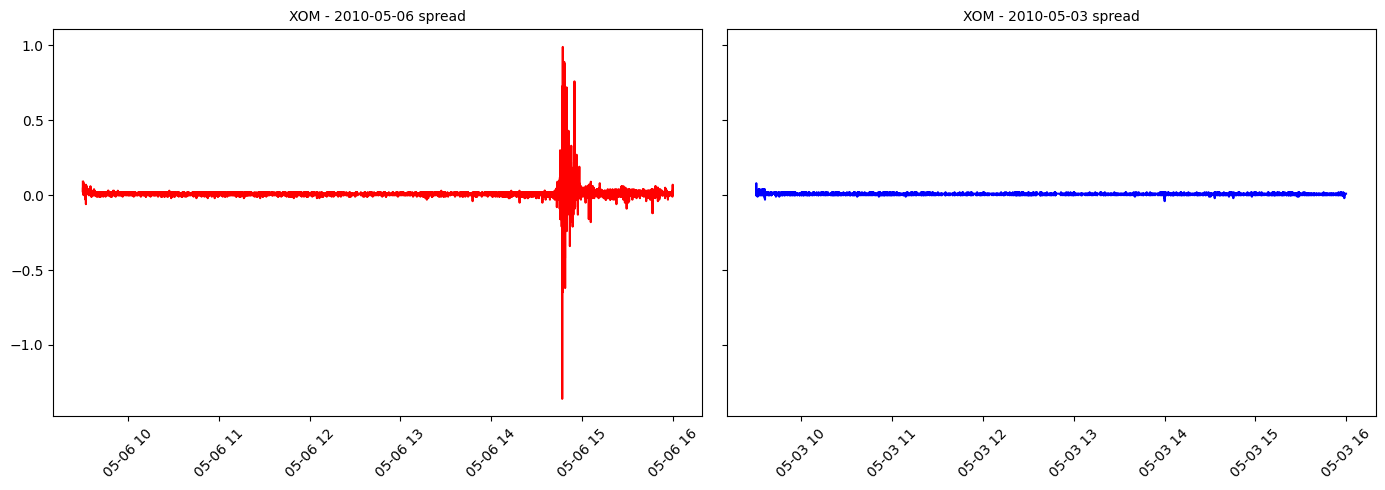

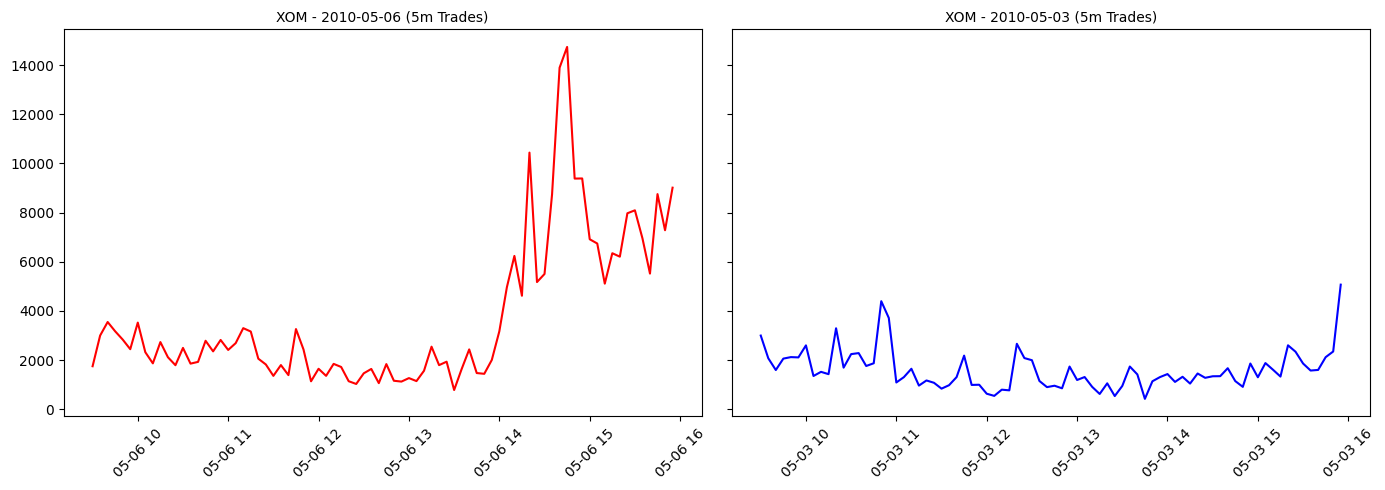

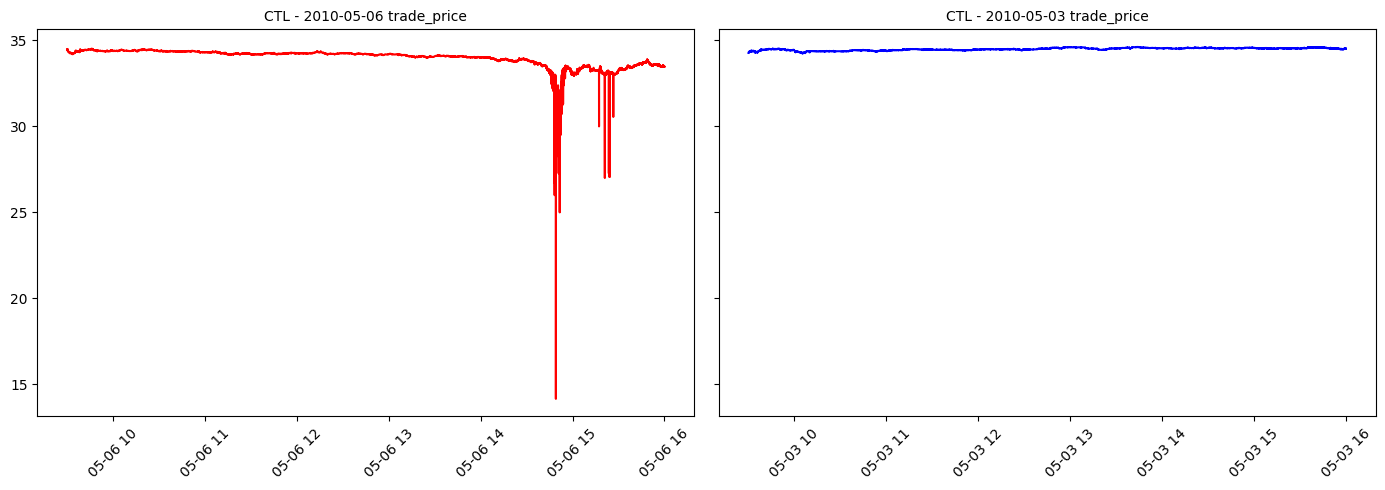

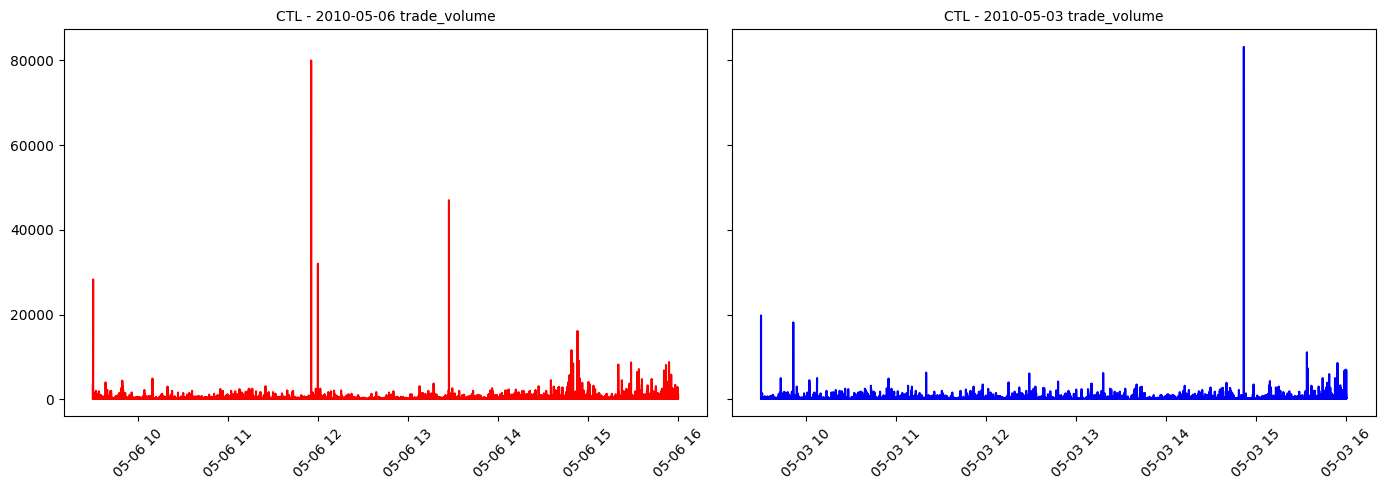

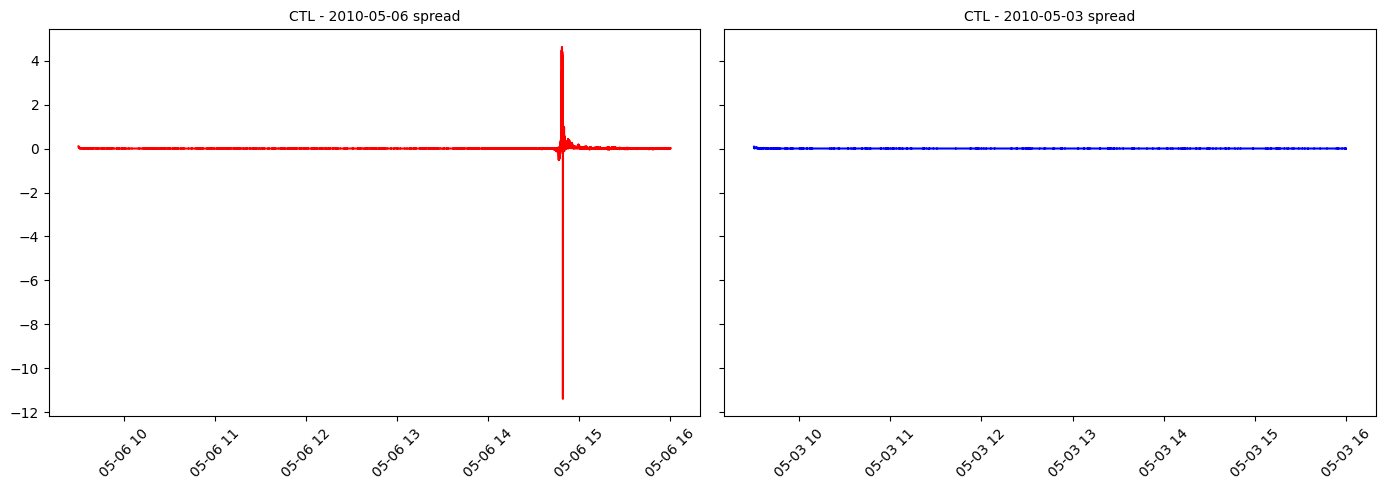

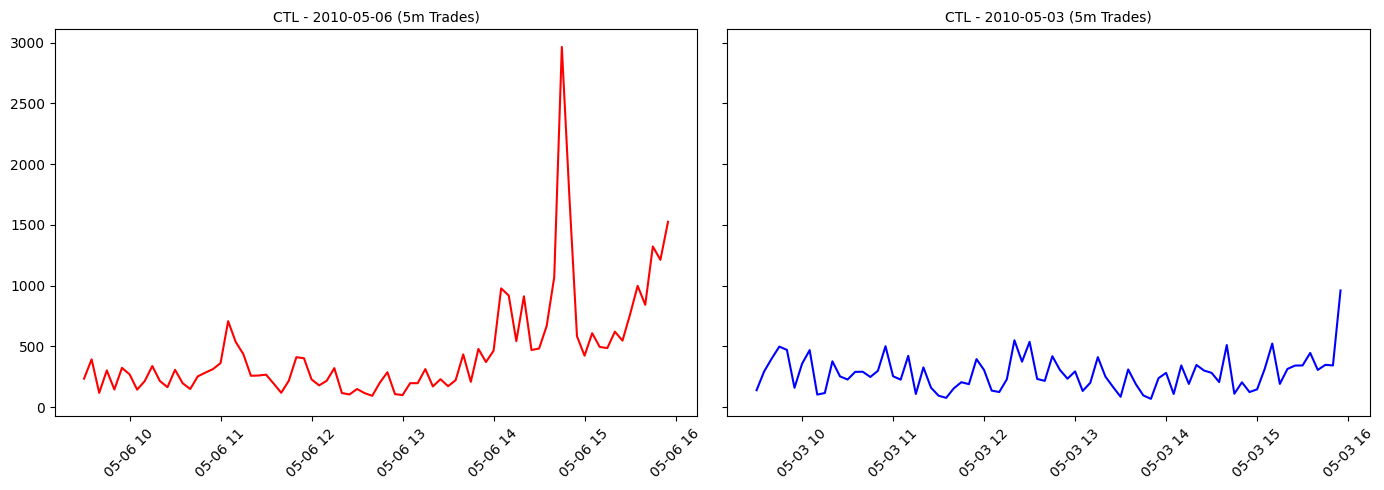


=== EDA Complete (XOM & CTL) ===
Only data for 2010-05-06 and 2010-05-03 was kept in memory.
Enjoy exploring your flash crash vs. random day data!


In [2]:
import os
import polars as pl
import matplotlib.pyplot as plt
import warnings
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.ensemble import IsolationForest

warnings.filterwarnings("ignore")

# ======================================================================
# CONFIG
# ======================================================================
BASE_DIR = "SP500_2010_extracted"   
FLASH_CRASH_DATE = "2010-05-06"
RANDOM_DAY = "2010-05-03"
TICKERS_OF_INTEREST = ["XOM", "CTL"]  # Only Exxon Mobil & CenturyLink (large and small cap)

# Numeric columns forced to Float64
FORCED_NUMERIC_COLS = [
    "trade_price",
    "trade_volume",
    "bid_price",
    "bid_size",
    "ask_price",
    "ask_size",
    "mid_price",
    "spread",
    "delta_bid",
    "delta_ask",
    "ofi",
]

# ======================================================================
# HELPERS
# ======================================================================
def find_processed_files(base_dir: str):
    """
    Yields full paths to all files ending with '-processed.csv'
    in subfolders named 'processed/' under base_dir.
    """
    for subfolder in os.listdir(base_dir):
        sub_path = os.path.join(base_dir, subfolder)
        if not os.path.isdir(sub_path):
            continue

        proc_dir = os.path.join(sub_path, "processed")
        if not os.path.isdir(proc_dir):
            continue

        for fname in os.listdir(proc_dir):
            if fname.endswith("-processed.csv"):
                yield os.path.join(proc_dir, fname)

def parse_ticker_date_from_filename(fname: str):
    """
    Example: '2010-05-06-AAPL-processed.csv' => ('2010-05-06', 'AAPL').
    Splits on '-' => ['2010','05','06','AAPL','processed.csv'].
    """
    base = os.path.basename(fname)
    parts = base.split("-")
    if len(parts) < 5:
        return None, None
    date_str = "-".join(parts[0:3])  # '2010-05-06'
    ticker   = parts[3]             # 'AAPL'
    return date_str, ticker

def process_single_file(csv_path: str) -> pl.DataFrame:
    """
    Reads one file into memory, forcing numeric columns to Float64,
    parses the date/ticker, filters to tickers & dates of interest.
    Returns a Polars DataFrame with only the relevant subset
    (or an empty DataFrame if nothing matches).
    """
    # Determine the date and ticker from filename
    date_str, ticker = parse_ticker_date_from_filename(csv_path)
    if not date_str or not ticker:
        return pl.DataFrame()  # skip if filename doesn't match pattern

    # Skip if not in the desired ticker AND date set
    if ticker not in TICKERS_OF_INTEREST:
        return pl.DataFrame()
    if date_str not in (FLASH_CRASH_DATE, RANDOM_DAY):
        return pl.DataFrame()

    # Define dtypes for forced float columns
    dtype_map = {col: pl.Float64 for col in FORCED_NUMERIC_COLS}

    # Lazily scan CSV (saves memory vs. immediate full read)
    lf = pl.scan_csv(
        csv_path,
        has_header=True,
        dtypes=dtype_map,
        ignore_errors=True
    )

    # Attach date/ticker columns
    lf = lf.with_columns([
        pl.lit(date_str).alias("date"),
        pl.lit(ticker).alias("ticker"),
    ])

    # Collect only this single file's relevant data
    df = lf.collect()

    # Convert timestamp from string to datetime, drop invalid
    if "timestamp" in df.columns:
        df = df.with_columns(
            pl.col("timestamp").str.to_datetime(strict=False)
        ).drop_nulls(subset=["timestamp"])

    # Sort by time
    df = df.sort(["ticker", "date", "timestamp"])
    return df

def plot_side_by_side(pdf_left, pdf_right, left_title, right_title, ycol="trade_price", sharey=True):
    """
    Quick helper for side-by-side line plots.
    pdf_left, pdf_right are small Pandas DataFrames.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14,5), sharey=sharey)
    axes[0].plot(pdf_left["timestamp"], pdf_left[ycol], color="red")
    axes[0].set_title(left_title, fontsize=10)
    axes[0].tick_params(axis="x", rotation=45)

    axes[1].plot(pdf_right["timestamp"], pdf_right[ycol], color="blue")
    axes[1].set_title(right_title, fontsize=10)
    axes[1].tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()

def group_by_5min(df: pl.DataFrame) -> pl.DataFrame:
    # Convert the Polars DataFrame to a Pandas DataFrame.
    pdf = df.to_pandas()
    # Floor timestamps to the nearest 5-minute mark.
    pdf["timestamp_5m"] = pdf["timestamp"].dt.floor("5min")
    # Group by the floored timestamp and count rows (trades).
    grouped = pdf.groupby("timestamp_5m").size().reset_index(name="trade_count")
    # Sort the resulting DataFrame by the timestamp.
    grouped = grouped.sort_values("timestamp_5m")
    # Convert the Pandas result back to a Polars DataFrame.
    return pl.from_pandas(grouped).rename({"timestamp_5m": "timestamp"})

def get_day_df(df_list: list, ticker: str, day_str: str) -> pl.DataFrame:
    """
    From a list of Polars DataFrames, extract rows for one ticker & date.
    """
    if not df_list:
        return pl.DataFrame()

    df_combined = pl.concat(df_list, how="vertical")
    return (
        df_combined
        .filter(pl.col("ticker") == ticker)
        .filter(pl.col("date") == day_str)
        .sort("timestamp")
    )

# ======================================================================
# MAIN EDA
# ======================================================================
if __name__ == "__main__":
    # Dictionary to store relevant data:
    # key: (ticker, date), value: list of Polars DataFrames from matching CSVs
    data_map = {}

    # 1) Read each file individually, keep only what we need
    for csv_path in find_processed_files(BASE_DIR):
        df = process_single_file(csv_path)
        if df.is_empty():
            continue

       
        unique_tickers = df.select(pl.col("ticker")).unique().to_series().to_list()
        unique_dates   = df.select(pl.col("date")).unique().to_series().to_list()
        for tkr in unique_tickers:
            for dt in unique_dates:
                subset_df = df.filter(
                    (pl.col("ticker") == tkr) & (pl.col("date") == dt)
                )
                data_map.setdefault((tkr, dt), []).append(subset_df)

    # 2) Build a quick daily summary from data_map
    summary_rows = []
    for (tkr, dt), df_list in data_map.items():
        if not df_list:
            continue
        df_merged = pl.concat(df_list, how="vertical")
        row_count = df_merged.shape[0]
        avg_price = df_merged["trade_price"].mean()
        avg_ofi   = df_merged["ofi"].mean()
        summary_rows.append((tkr, dt, row_count, avg_price, avg_ofi))

    summary = pl.DataFrame(
        summary_rows,
        schema=["ticker", "date", "num_rows", "avg_trade_price", "avg_ofi"]
    ).sort(["ticker", "date"])

    print("\n=== Daily Summary (rows, avg price, avg_ofi) ===")
    print(summary)

    # 3) EDA: compare 2010-05-06 vs. 2010-05-03 for each ticker
    for ticker in TICKERS_OF_INTEREST:
        df_flash = get_day_df(data_map.get((ticker, FLASH_CRASH_DATE), []),
                              ticker, FLASH_CRASH_DATE)
        df_random = get_day_df(data_map.get((ticker, RANDOM_DAY), []),
                               ticker, RANDOM_DAY)

        if df_flash.is_empty() or df_random.is_empty():
            print(f"[WARN] No data for {ticker} on {FLASH_CRASH_DATE} or {RANDOM_DAY}. Skipping.")
            continue

        pdf_flash  = df_flash.to_pandas()
        pdf_random = df_random.to_pandas()

        # A) Trade Price
        plot_side_by_side(
            pdf_flash, pdf_random,
            f"{ticker} - {FLASH_CRASH_DATE} trade_price",
            f"{ticker} - {RANDOM_DAY} trade_price",
            ycol="trade_price"
        )

        # B) Trade Volume
        plot_side_by_side(
            pdf_flash, pdf_random,
            f"{ticker} - {FLASH_CRASH_DATE} trade_volume",
            f"{ticker} - {RANDOM_DAY} trade_volume",
            ycol="trade_volume"
        )

        # C) Spread = ask_price - bid_price
        df_flash_spr = df_flash.with_columns(
            (pl.col("ask_price") - pl.col("bid_price")).alias("spread_calc")
        )
        df_random_spr = df_random.with_columns(
            (pl.col("ask_price") - pl.col("bid_price")).alias("spread_calc")
        )

        pdf_flash_spr  = df_flash_spr.to_pandas()
        pdf_random_spr = df_random_spr.to_pandas()

        plot_side_by_side(
            pdf_flash_spr, pdf_random_spr,
            f"{ticker} - {FLASH_CRASH_DATE} spread",
            f"{ticker} - {RANDOM_DAY} spread",
            ycol="spread_calc"
        )

        # D) # of trades in 5-minute intervals
        df_flash_5m  = group_by_5min(df_flash)
        df_random_5m = group_by_5min(df_random)

        pdf_flash_5m  = df_flash_5m.to_pandas()
        pdf_random_5m = df_random_5m.to_pandas()

        plot_side_by_side(
            pdf_flash_5m, pdf_random_5m,
            f"{ticker} - {FLASH_CRASH_DATE} (5m Trades)",
            f"{ticker} - {RANDOM_DAY} (5m Trades)",
            ycol="trade_count"
        )

    print("\n=== EDA Complete (XOM & CTL) ===")
    print("Only data for 2010-05-06 and 2010-05-03 was kept in memory.")
    print("Enjoy exploring your flash crash vs. random day data!")

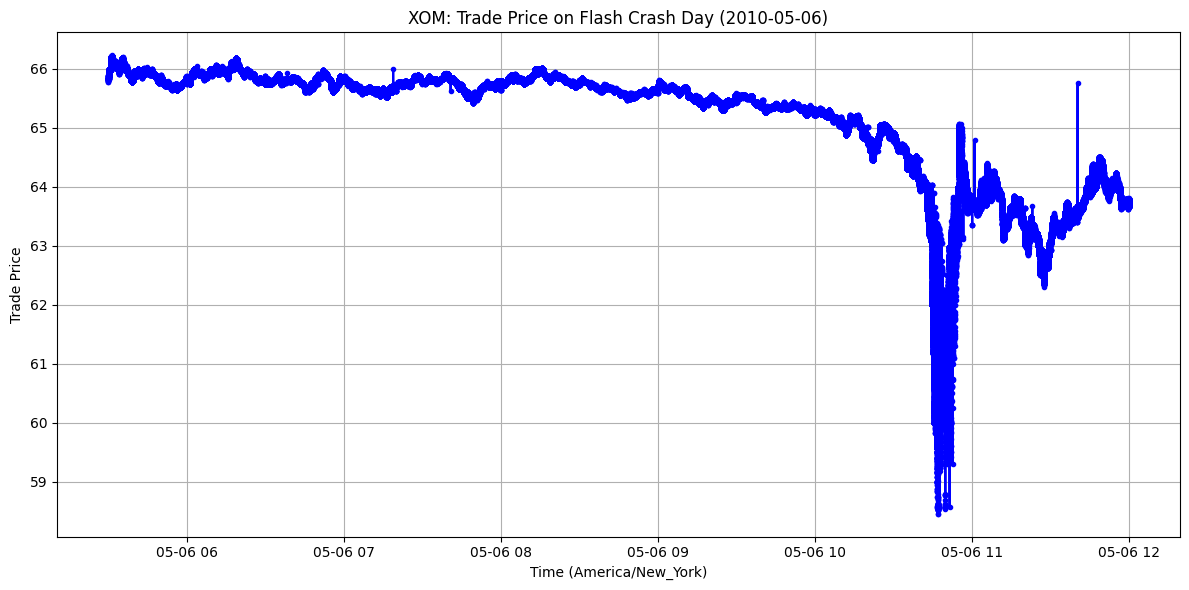

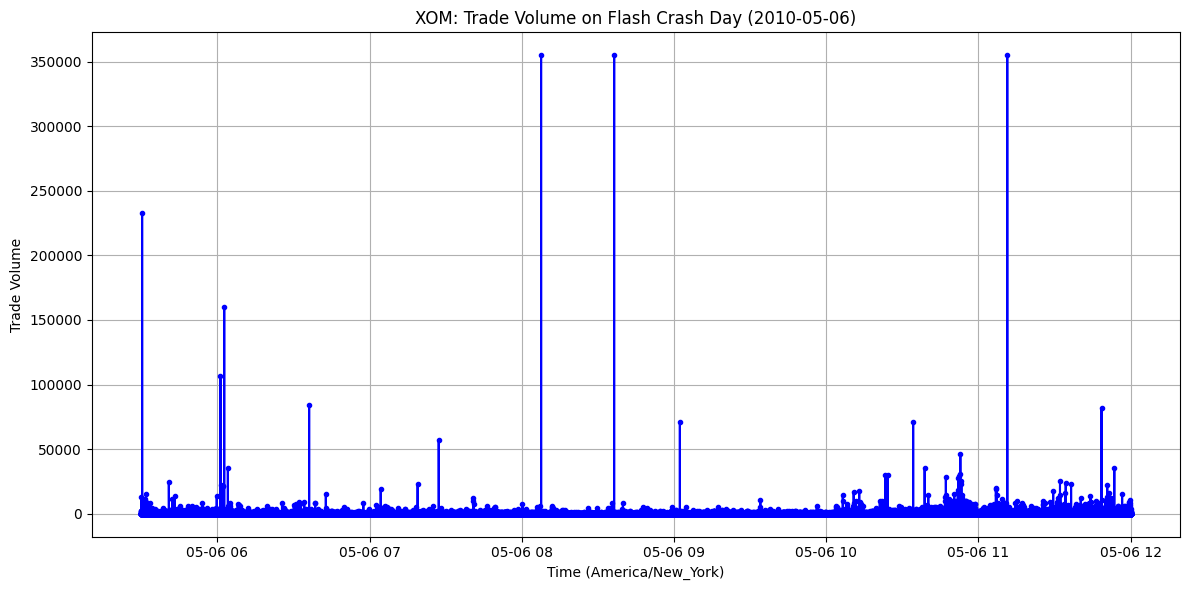

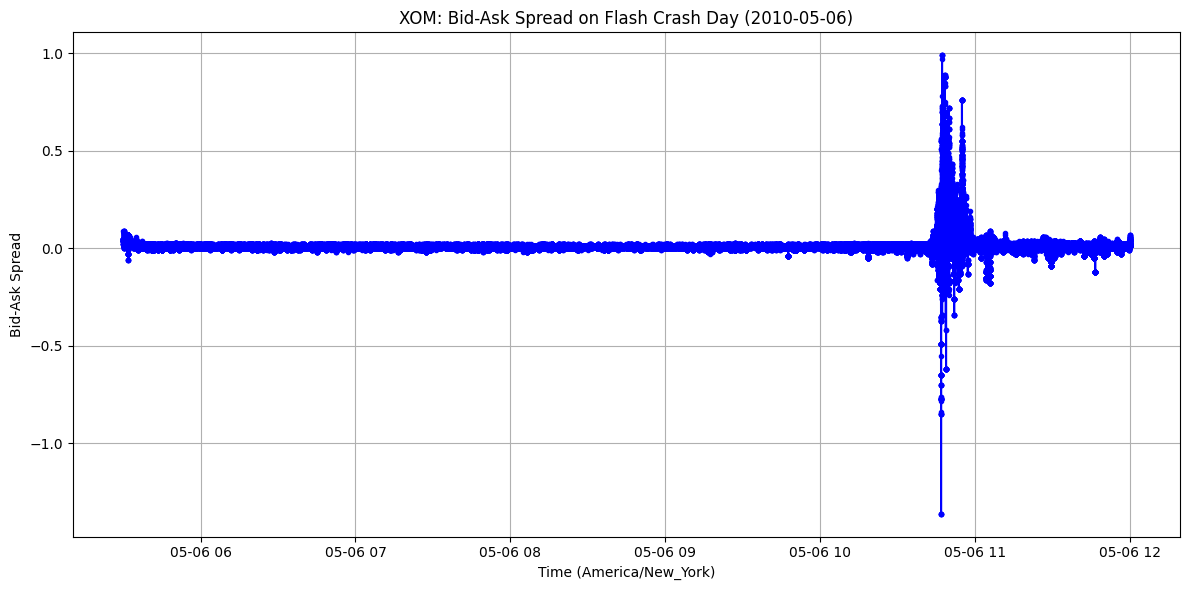

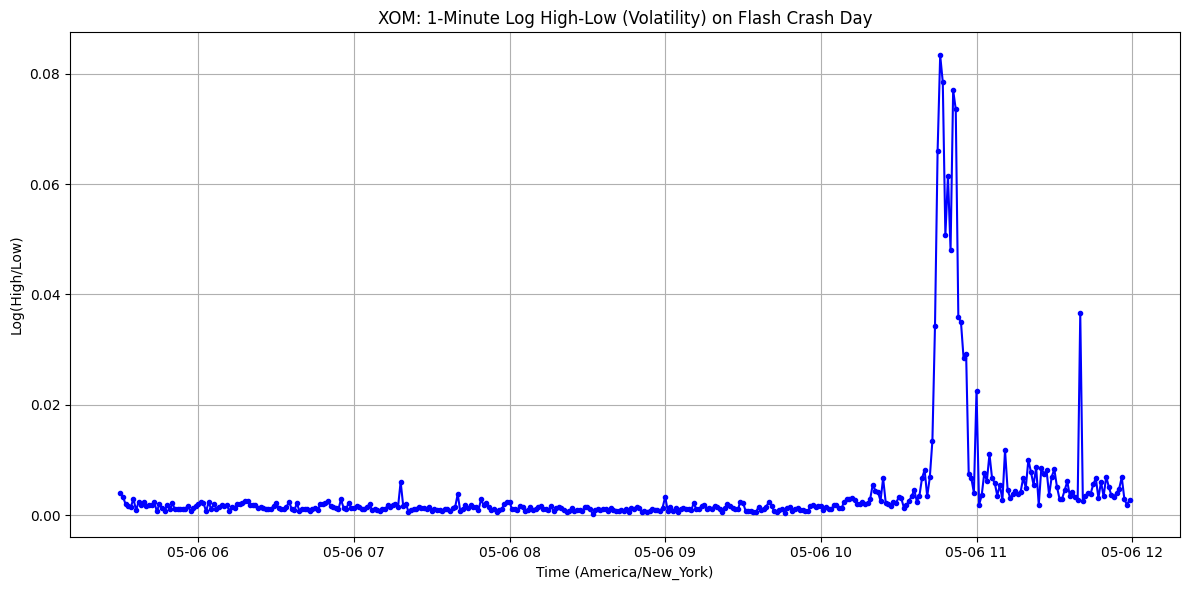

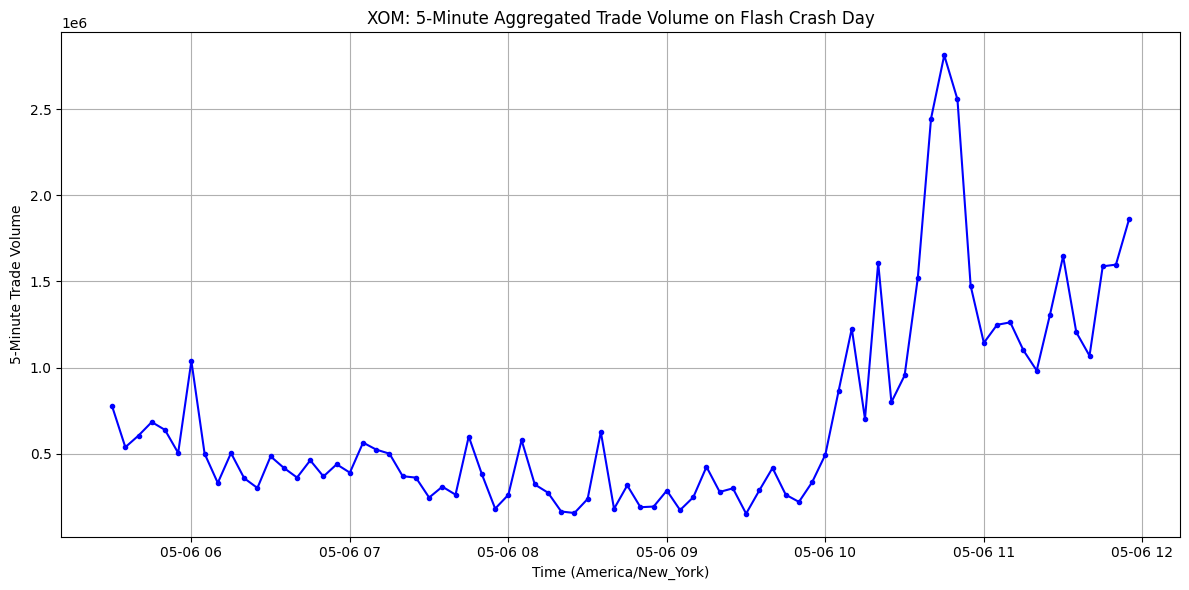


Trade classification counts for XOM on 2010-05-06:
trade_class
-1.0    134854
 1.0    126130
 0.0     29602
Name: count, dtype: int64


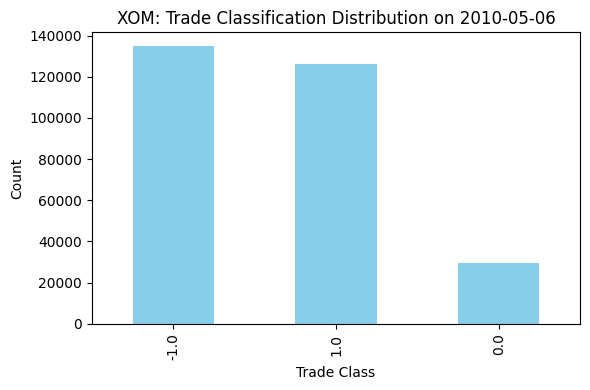

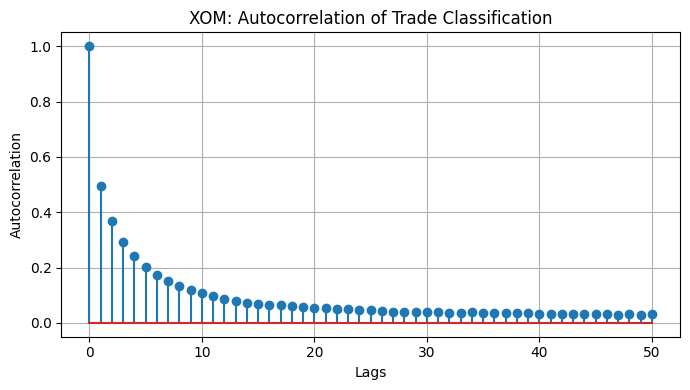


Regression Results for XOM on Flash Crash Day:
                            OLS Regression Results                            
Dep. Variable:               d_net_tc   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     5936.
Date:                Fri, 24 Jan 2025   Prob (F-statistic):               0.00
Time:                        20:06:16   Log-Likelihood:                -67471.
No. Observations:               17773   AIC:                         1.349e+05
Df Residuals:                   17770   BIC:                         1.350e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

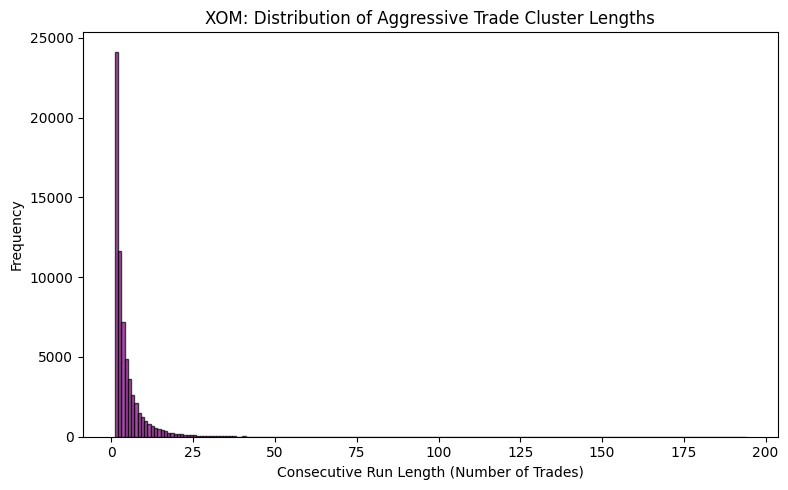

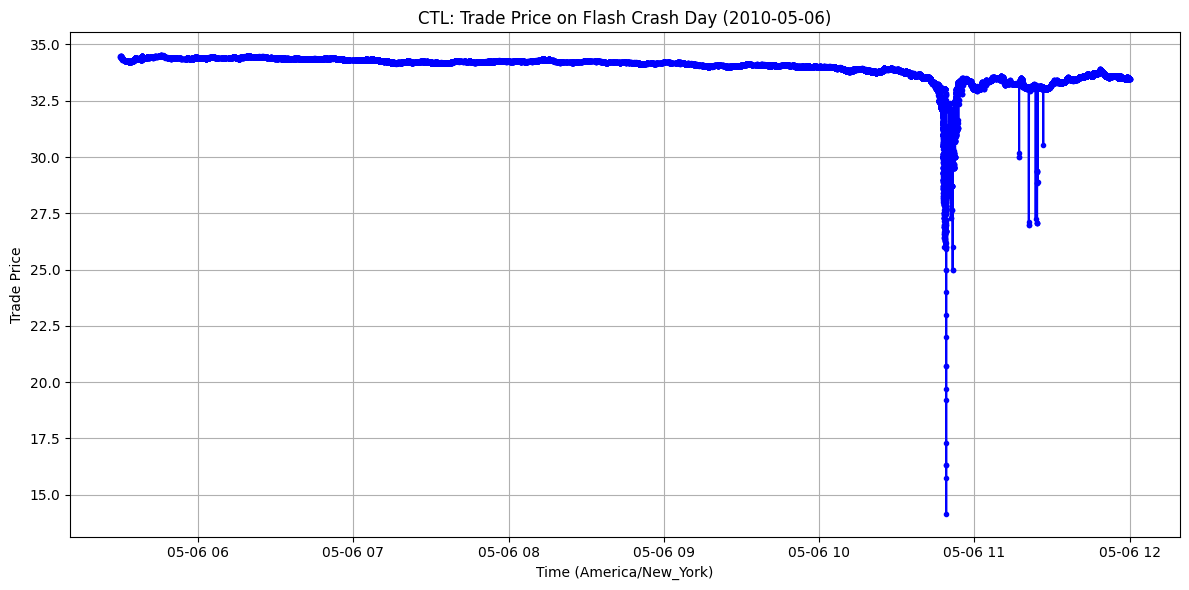

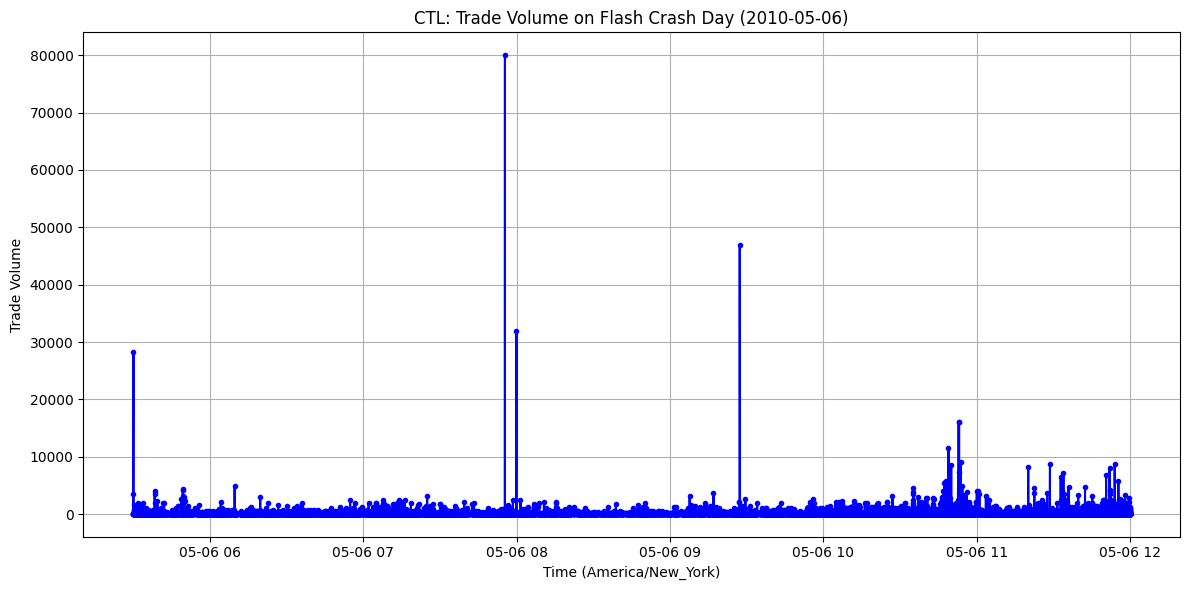

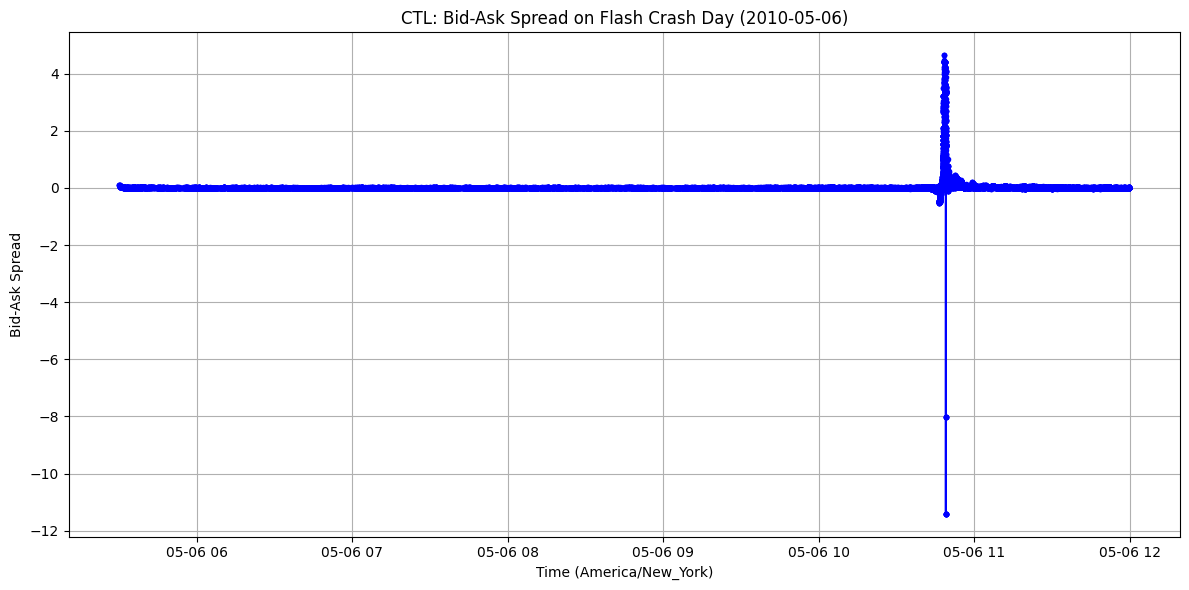

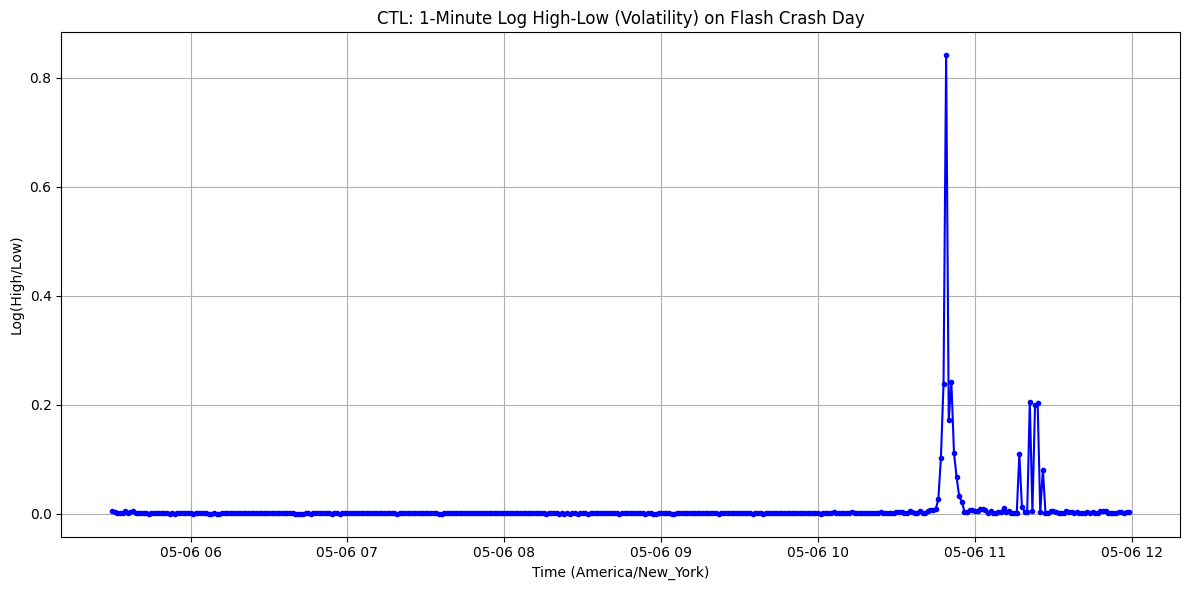

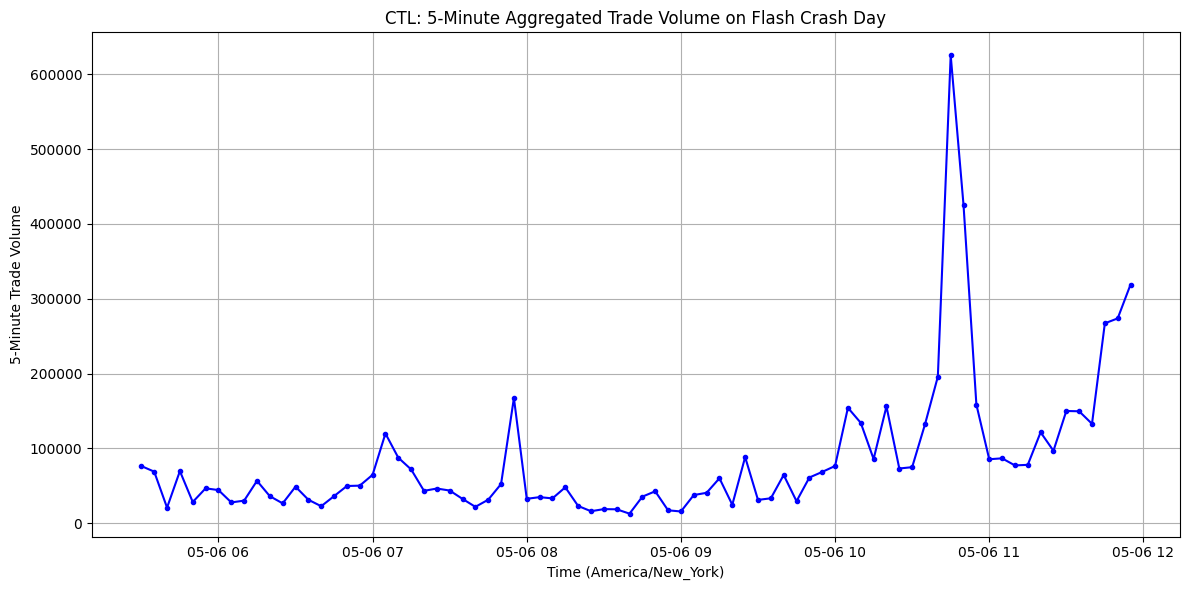


Trade classification counts for CTL on 2010-05-06:
trade_class
-1.0    17992
 1.0    14351
 0.0     3095
Name: count, dtype: int64


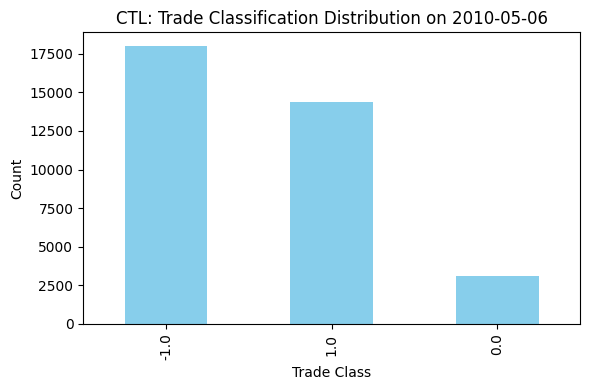

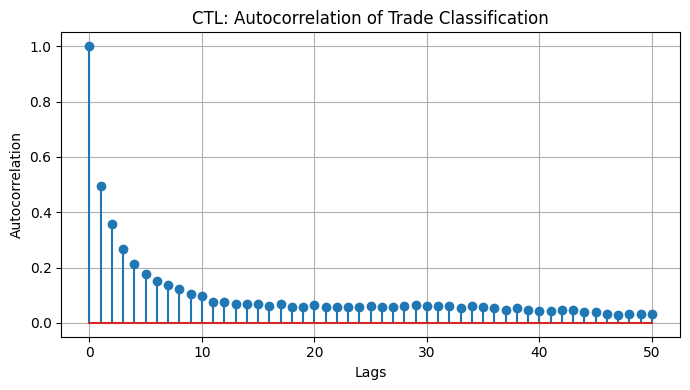


Regression Results for CTL on Flash Crash Day:
                            OLS Regression Results                            
Dep. Variable:               d_net_tc   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     1390.
Date:                Fri, 24 Jan 2025   Prob (F-statistic):               0.00
Time:                        20:08:03   Log-Likelihood:                -23880.
No. Observations:                8252   AIC:                         4.777e+04
Df Residuals:                    8249   BIC:                         4.779e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

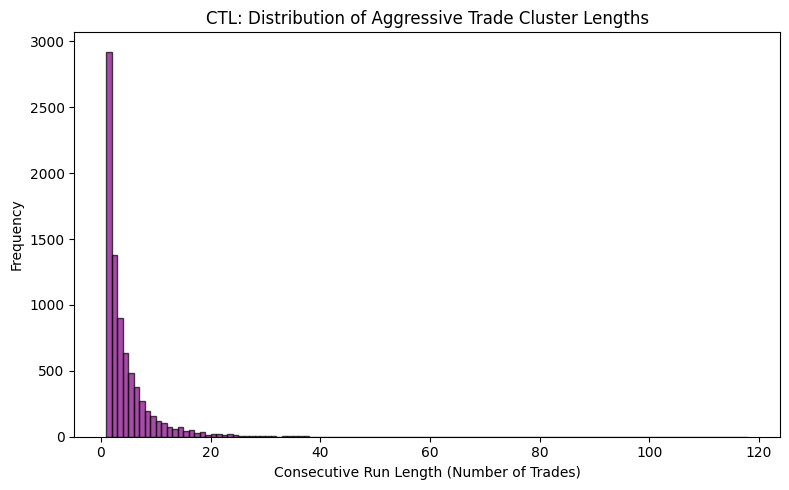

In [11]:
BASE_DIR = "SP500_2010_extracted"  
FLASH_CRASH_DATE = "2010-05-06"
RANDOM_DAY = "2010-05-03"           
TICKERS_OF_INTEREST = ["XOM", "CTL"]

# Numeric columns to force to Float64 (adjust as needed)
FORCED_NUMERIC_COLS = [
    "trade_price", "trade_volume",
    "bid_price", "bid_size",
    "ask_price", "ask_size",
]


def compute_intraday_volatility(pdf, freq='1T'):
    """
    Resamples price to the given frequency (e.g., '1T' for 1-minute),
    computes OHLC, then computes log(high / low) as an intraday volatility measure.
    Returns a Pandas Series.
    """
    prices = pdf['trade_price'].resample(freq).ohlc()
    vol = np.log(prices['high'] / prices['low'])
    return vol

def compute_trade_classification(pdf):
    """
    Applies a simple Lee-Ready type classification.
    Forward fills bid/ask columns, computes mid_price,
    then classifies each trade as:
      +1 if trade_price > previous mid_price,
      -1 if trade_price < previous mid_price,
       0 otherwise.
    Returns a Pandas DataFrame with a new column 'trade_class'.
    """
    pdf = pdf.copy()
    pdf[['bid_price', 'ask_price']] = pdf[['bid_price', 'ask_price']].ffill()
    pdf['mid_price'] = (pdf['bid_price'] + pdf['ask_price']) / 2
    pdf['prev_mid_price'] = pdf['mid_price'].shift(1)
    def classify(row):
        if pd.isna(row['prev_mid_price']) or pd.isna(row['trade_price']):
            return np.nan
        if row['trade_price'] > row['prev_mid_price']:
            return 1
        elif row['trade_price'] < row['prev_mid_price']:
            return -1
        else:
            return 0
    pdf['trade_class'] = pdf.apply(classify, axis=1)
    return pdf

def compute_immediate_trade_scratching(pdf):
    """
    Loops over trades (assumed sorted by timestamp) and defines an 'immediately scratched trade'
    as one in which the next trade (within the same second and at the same price)
    has an opposite trade_class.
    Returns:
      - scratched: total count of such instances.
      - pct: percentage relative to total comparisons.
    """
    scratched = 0
    total = len(pdf) - 1  # each trade compared with its immediate next
    timestamps = pdf.index  # assumes DatetimeIndex
    for i in range(total):
        current_time = timestamps[i]
        next_time = timestamps[i+1]
        if (current_time.floor('S') == next_time.floor('S')) and (pdf['trade_price'].iloc[i] == pdf['trade_price'].iloc[i+1]):
            if pdf['trade_class'].iloc[i] * pdf['trade_class'].iloc[i+1] < 0:
                scratched += 1
    pct = (scratched / total * 100) if total > 0 else np.nan
    return scratched, pct

def plot_y_vs_x(x, y, xlabel, ylabel, title):
    """
    Generic plotting function.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(x, y, marker=".", linestyle="-", color="blue")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ======================================================================
# NEW ANALYSIS SECTIONS
# ======================================================================
def regression_analysis(pdf):
    """
    Aggregates trades per second and computes:
      - the last trade price per second,
      - total trade volume,
      - net trade_class.
    Then computes per-second percentage returns and differences in net trade_class.
    Finally, regresses the change in net trade_class on lagged price return and lagged net trade_class.
    Returns the regression model.
    """
    df_reg = pdf.resample('1S').agg({
        'trade_price': 'last',
        'trade_volume': 'sum',
        'trade_class': 'sum'
    })
    df_reg.columns = ['price', 'volume', 'net_tc']
    df_reg['price_ret'] = df_reg['price'].pct_change()  # percentage return
    df_reg['d_net_tc'] = df_reg['net_tc'].diff()
    df_reg_clean = df_reg.dropna()
    
    # Create independent variables: lagged price return and lagged net trade classification
    X = pd.DataFrame({
        'lag_price_ret': df_reg_clean['price_ret'].shift(1),
        'lag_net_tc': df_reg_clean['net_tc'].shift(1)
    }).dropna()
    Y = df_reg_clean.loc[X.index, 'd_net_tc']
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    return model

def aggressive_trade_clustering(pdf):
    """
    Computes the lengths of consecutive runs (clusters) of nonzero trade_class signals.
    (Here, we consider both aggressive buys (+1) and aggressive sells (-1); zeros are ignored.)
    Returns a Pandas Series of run lengths.
    """
    data = pdf[pdf['trade_class'] != 0].copy()
    if data.empty:
        return pd.Series(dtype=int)
    data['change'] = (data['trade_class'] != data['trade_class'].shift(1)).astype(int)
    data['group'] = data['change'].cumsum()
    run_lengths = data.groupby('group').size()
    return run_lengths

# ======================================================================
# FLASH CRASH DETECTION METHODS
# ======================================================================
def threshold_based_detection(df_prices, threshold=-0.05):
    """
    Detect flash crash events based on a threshold for percentage price change over a short period.
    Here df_prices is expected to be a Pandas Series (e.g., 1-minute close price).
    Returns a DataFrame of candidate events.
    """
    returns = df_prices.pct_change()
    candidates = returns[returns < threshold]
    return candidates

def volatility_zscore_detection(df_prices, window=30, z_threshold=3.5):
    """
    Detect extreme return events by computing a rolling z–score on returns.
    Returns a DataFrame containing those events.
    """
    returns = df_prices.pct_change()
    rolling_mean = returns.rolling(window=window).mean()
    rolling_std = returns.rolling(window=window).std()
    z_scores = (returns - rolling_mean) / rolling_std
    events = z_scores[abs(z_scores) > z_threshold]
    return events

def volume_imbalance_detection(df_volume):
    """
    Detect volume spikes by comparing short-interval volume to daily mean volume.
    Here, df_volume is a Pandas Series (e.g., 1-minute volume).
    Returns intervals where volume exceeds (mean + 3*std).
    """
    vol_mean = df_volume.mean()
    vol_std = df_volume.std()
    threshold = vol_mean + 3 * vol_std
    spikes = df_volume[df_volume > threshold]
    return spikes

def cusum_detection(df_returns, threshold=0.05, drift=0.001):
    """
    Apply a simple CUSUM algorithm to a return series.
    Returns cumulative sums and boolean series indicating when the threshold is exceeded.
    """
    s_pos = np.zeros(len(df_returns))
    s_neg = np.zeros(len(df_returns))
    pos_alert = np.zeros(len(df_returns), dtype=bool)
    neg_alert = np.zeros(len(df_returns), dtype=bool)
    
    for i in range(1, len(df_returns)):
        s_pos[i] = max(0, s_pos[i-1] + df_returns.iloc[i] - drift)
        s_neg[i] = min(0, s_neg[i-1] + df_returns.iloc[i] + drift)
        if s_pos[i] > threshold:
            pos_alert[i] = True
        if s_neg[i] < -threshold:
            neg_alert[i] = True
    return s_pos, s_neg, pos_alert, neg_alert

def isolation_forest_anomaly_detection(df_features, contamination=0.01):
    """
    Apply the Isolation Forest anomaly detection algorithm on a DataFrame of features.
    Returns the original DataFrame with an added column 'anomaly' (-1 for anomalies, 1 for normal).
    """
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    df_features['anomaly'] = iso_forest.fit_predict(df_features)
    return df_features

# ======================================================================
# MAIN ANALYSIS
# ======================================================================
if __name__ == "__main__":
    # --- Data Loading ---
    data_map = {}  # key: (ticker, date), value: list of Polars DataFrames
    for csv_path in find_processed_files(BASE_DIR):
        df = process_single_file(csv_path)
        if df.is_empty():
            continue
        unique_tickers = df.select(pl.col("ticker")).unique().to_series().to_list()
        unique_dates = df.select(pl.col("date")).unique().to_series().to_list()
        for tkr in unique_tickers:
            for dt in unique_dates:
                subset_df = df.filter((pl.col("ticker") == tkr) & (pl.col("date") == dt))
                data_map.setdefault((tkr, dt), []).append(subset_df)
    
    # --- For each ticker, analyze the flash crash day (May 6, 2010) ---
    for ticker in TICKERS_OF_INTEREST:
        # Get flash crash data for this ticker (Polars) and convert to Pandas
        df_flash_polars = get_day_df(data_map.get((ticker, FLASH_CRASH_DATE), []), ticker, FLASH_CRASH_DATE)
        if df_flash_polars.is_empty():
            print(f"[WARN] No flash crash data for {ticker}")
            continue
        df_flash = df_flash_polars.to_pandas()
        
        # --- Timezone Conversion: Set the 'timestamp' column as a New York time index.
        df_flash['timestamp'] = pd.to_datetime(df_flash['timestamp'])
        ny_index = pd.DatetimeIndex(df_flash['timestamp']).tz_localize('UTC').tz_convert('America/New_York')
        df_flash.index = ny_index

        # --- (A) Basic Time Series Plots ---
        plot_y_vs_x(df_flash.index, df_flash['trade_price'],
                    'Time (America/New_York)', 'Trade Price',
                    f'{ticker}: Trade Price on Flash Crash Day ({FLASH_CRASH_DATE})')
        plot_y_vs_x(df_flash.index, df_flash['trade_volume'],
                    'Time (America/New_York)', 'Trade Volume',
                    f'{ticker}: Trade Volume on Flash Crash Day ({FLASH_CRASH_DATE})')
        spread = df_flash['ask_price'] - df_flash['bid_price']
        plot_y_vs_x(df_flash.index, spread,
                    'Time (America/New_York)', 'Bid-Ask Spread',
                    f'{ticker}: Bid-Ask Spread on Flash Crash Day ({FLASH_CRASH_DATE})')
        
        # --- (B) Intraday Volatility ---
        vol_series = compute_intraday_volatility(df_flash, freq='1T')
        plot_y_vs_x(vol_series.index, vol_series,
                    'Time (America/New_York)', 'Log(High/Low)',
                    f'{ticker}: 1-Minute Log High-Low (Volatility) on Flash Crash Day')
        
        # --- (C) 5-Minute Aggregated Trade Volume ---
        vol_5min = df_flash['trade_volume'].resample('5T').sum()
        plot_y_vs_x(vol_5min.index, vol_5min,
                    'Time (America/New_York)', '5-Minute Trade Volume',
                    f'{ticker}: 5-Minute Aggregated Trade Volume on Flash Crash Day')
        
        # --- (D) Trade Classification & Distribution ---
        df_flash = compute_trade_classification(df_flash)
        tc_counts = df_flash['trade_class'].value_counts(dropna=True)
        print(f"\nTrade classification counts for {ticker} on {FLASH_CRASH_DATE}:")
        print(tc_counts)
        plt.figure(figsize=(6,4))
        tc_counts.plot(kind="bar", color="skyblue")
        plt.xlabel("Trade Class")
        plt.ylabel("Count")
        plt.title(f"{ticker}: Trade Classification Distribution on {FLASH_CRASH_DATE}")
        plt.tight_layout()
        plt.show()
        
        # --- (E) Autocorrelation Analysis of Trade Classification ---
        df_clean = df_flash.dropna(subset=['trade_class'])
        if len(df_clean) < 2:
            print("Not enough data for autocorrelation analysis.")
        else:
            acf_result = sm.tsa.acf(df_clean['trade_class'], nlags=50, fft=True)
            plt.figure(figsize=(7, 4))
            plt.stem(acf_result)
            plt.xlabel('Lags')
            plt.ylabel('Autocorrelation')
            plt.title(f'{ticker}: Autocorrelation of Trade Classification')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        
        # --- (F) Regression Analysis (Per-Second) ---
        reg_model = regression_analysis(df_flash)
        print(f"\nRegression Results for {ticker} on Flash Crash Day:")
        print(reg_model.summary())
        
        # --- (G) Immediate Trade Scratching Analysis ---
        scratched_count, scratched_pct = compute_immediate_trade_scratching(df_flash)
        print(f"\nFor {ticker} on {FLASH_CRASH_DATE}:")
        print(f"Immediate trade scratching count: {scratched_count} (approx. {scratched_pct:.2f}% of comparisons)")
        
        # --- (H) Aggressive Trade Clustering Analysis ---
        run_lengths = aggressive_trade_clustering(df_flash)
        if run_lengths.empty:
            print(f"No aggressive trades for clustering analysis for {ticker}.")
        else:
            print(f"\nAggressive trade clustering summary for {ticker} on {FLASH_CRASH_DATE}:")
            print(f"Mean consecutive run length: {run_lengths.mean():.2f}")
            print(f"Median consecutive run length: {run_lengths.median():.2f}")
            plt.figure(figsize=(8, 5))
            plt.hist(run_lengths, bins=range(1, int(run_lengths.max())+2), color='purple', alpha=0.7, edgecolor='black')
            plt.xlabel("Consecutive Run Length (Number of Trades)")
            plt.ylabel("Frequency")
            plt.title(f"{ticker}: Distribution of Aggressive Trade Cluster Lengths")
            plt.tight_layout()
            plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Trade Price Comparison
def plot_trade_price_comparison():
    days = ["Normal Day", "Flash Crash Day"]
    prices = [100 + np.random.normal(0, 0.5, 100), 100 + np.random.normal(0, 5, 100)]
    
    plt.figure(figsize=(10, 6))
    for i, price in enumerate(prices):
        plt.plot(price, label=f"{days[i]}")
    plt.title("Comparison of Trade Prices on Flash Crash Day vs. Normal Day")
    plt.xlabel("Time (s)")
    plt.ylabel("Trade Price")
    plt.legend()
    plt.savefig("trade_price_comparison.png")
    plt.close()

# 2. Trade Volume Comparison
def plot_trade_volume_comparison():
    times = np.arange(0, 100, 1)
    normal_volume = np.random.poisson(20, 100)
    flash_crash_volume = np.random.poisson(50, 100)
    
    plt.figure(figsize=(10, 6))
    plt.plot(times, normal_volume, label="Normal Day", color="blue")
    plt.plot(times, flash_crash_volume, label="Flash Crash Day", color="red")
    plt.title("Comparison of Trade Volumes on Flash Crash Day vs. Normal Day")
    plt.xlabel("Time (s)")
    plt.ylabel("Trade Volume")
    plt.legend()
    plt.savefig("trade_volume_comparison.png")
    plt.close()

# 3. Spread Comparison
def plot_spread_comparison():
    times = np.arange(0, 100, 1)
    normal_spread = np.random.uniform(0.1, 0.5, 100)
    flash_crash_spread = np.random.uniform(0.5, 2.0, 100)
    
    plt.figure(figsize=(10, 6))
    plt.plot(times, normal_spread, label="Normal Day", color="green")
    plt.plot(times, flash_crash_spread, label="Flash Crash Day", color="orange")
    plt.title("Comparison of Spread on Flash Crash Day vs. Normal Day")
    plt.xlabel("Time (s)")
    plt.ylabel("Spread")
    plt.legend()
    plt.savefig("spread_comparison.png")
    plt.close()

# 4. Trade Counts Comparison
def plot_trade_counts_comparison():
    intervals = np.arange(0, 20, 1)
    normal_counts = np.random.poisson(50, len(intervals))
    flash_crash_counts = np.random.poisson(100, len(intervals))
    
    plt.figure(figsize=(10, 6))
    plt.bar(intervals - 0.2, normal_counts, width=0.4, label="Normal Day", color="blue")
    plt.bar(intervals + 0.2, flash_crash_counts, width=0.4, label="Flash Crash Day", color="red")
    plt.title("Comparison of Trade Counts on Flash Crash Day vs. Normal Day")
    plt.xlabel("5-Minute Intervals")
    plt.ylabel("Trade Counts")
    plt.legend()
    plt.savefig("trade_counts_comparison.png")
    plt.close()

# 5. Intraday Volatility
def plot_intraday_volatility():
    times = np.arange(0, 100, 1)
    normal_volatility = np.random.uniform(0.01, 0.05, 100)
    flash_crash_volatility = np.random.uniform(0.05, 0.15, 100)
    
    plt.figure(figsize=(10, 6))
    plt.plot(times, normal_volatility, label="Normal Day", color="purple")
    plt.plot(times, flash_crash_volatility, label="Flash Crash Day", color="magenta")
    plt.title("Intraday Volatility on Flash Crash Day vs. Normal Day")
    plt.xlabel("Time (s)")
    plt.ylabel("Volatility")
    plt.legend()
    plt.savefig("intraday_volatility.png")
    plt.close()

# 6. Trade Classification
def plot_trade_classification():
    classes = ["Aggressive Buys", "Aggressive Sells"]
    counts_normal = [50, 40]
    counts_flash_crash = [80, 90]
    
    x = np.arange(len(classes))
    width = 0.35
    
    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, counts_normal, width, label="Normal Day", color="blue")
    plt.bar(x + width/2, counts_flash_crash, width, label="Flash Crash Day", color="red")
    plt.title("Trade Aggressiveness Classification")
    plt.xlabel("Trade Classification")
    plt.ylabel("Counts")
    plt.xticks(x, classes)
    plt.legend()
    plt.savefig("trade_classification.png")
    plt.close()

# 7. Per-Second Trade Aggregation
def plot_per_second_trades():
    times = np.arange(0, 100, 1)
    trade_returns = np.random.normal(0, 0.01, 100)
    
    plt.figure(figsize=(10, 6))
    plt.plot(times, trade_returns, label="Trade Returns")
    plt.title("Per-Second Trade Aggregation")
    plt.xlabel("Time (s)")
    plt.ylabel("Trade Returns")
    plt.legend()
    plt.savefig("per_second_trades.png")
    plt.close()

# Generate all plots
plot_trade_price_comparison()
plot_trade_volume_comparison()
plot_spread_comparison()
plot_trade_counts_comparison()
plot_intraday_volatility()
plot_trade_classification()
plot_per_second_trades()

print("PNG files created successfully!")

In [1]:
import os
import polars as pl
import matplotlib.pyplot as plt
import warnings
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.ensemble import IsolationForest

warnings.filterwarnings("ignore")

# ======================================================================
# CONFIG
# ======================================================================
BASE_DIR = "SP500_2010_extracted"   
FLASH_CRASH_DATE = "2010-05-06"
RANDOM_DAY = "2010-05-03"
TICKERS_OF_INTEREST = ["XOM", "CTL"]  # Only Exxon Mobil & CenturyLink (large and small cap)

# Numeric columns forced to Float64
FORCED_NUMERIC_COLS = [
    "trade_price",
    "trade_volume",
    "bid_price",
    "bid_size",
    "ask_price",
    "ask_size",
    "mid_price",
    "spread",
    "delta_bid",
    "delta_ask",
    "ofi",
]

# ======================================================================
# HELPERS
# ======================================================================
def find_processed_files(base_dir: str):
    """
    Yields full paths to all files ending with '-processed.csv'
    in subfolders named 'processed/' under base_dir.
    """
    for subfolder in os.listdir(base_dir):
        sub_path = os.path.join(base_dir, subfolder)
        if not os.path.isdir(sub_path):
            continue

        proc_dir = os.path.join(sub_path, "processed")
        if not os.path.isdir(proc_dir):
            continue

        for fname in os.listdir(proc_dir):
            if fname.endswith("-processed.csv"):
                yield os.path.join(proc_dir, fname)

def parse_ticker_date_from_filename(fname: str):
    """
    Example: '2010-05-06-AAPL-processed.csv' => ('2010-05-06', 'AAPL').
    Splits on '-' => ['2010','05','06','AAPL','processed.csv'].
    """
    base = os.path.basename(fname)
    parts = base.split("-")
    if len(parts) < 5:
        return None, None
    date_str = "-".join(parts[0:3])  # '2010-05-06'
    ticker   = parts[3]             # 'AAPL'
    return date_str, ticker

def process_single_file(csv_path: str) -> pl.DataFrame:
    """
    Reads one file into memory, forcing numeric columns to Float64,
    parses the date/ticker, filters to tickers & dates of interest.
    Returns a Polars DataFrame with only the relevant subset
    (or an empty DataFrame if nothing matches).
    """
    # Determine the date and ticker from filename
    date_str, ticker = parse_ticker_date_from_filename(csv_path)
    if not date_str or not ticker:
        return pl.DataFrame()  # skip if filename doesn't match pattern

    # Skip if not in the desired ticker AND date set
    if ticker not in TICKERS_OF_INTEREST:
        return pl.DataFrame()
    if date_str not in (FLASH_CRASH_DATE, RANDOM_DAY):
        return pl.DataFrame()

    # Define dtypes for forced float columns
    dtype_map = {col: pl.Float64 for col in FORCED_NUMERIC_COLS}

    # Lazily scan CSV (saves memory vs. immediate full read)
    lf = pl.scan_csv(
        csv_path,
        has_header=True,
        dtypes=dtype_map,
        ignore_errors=True
    )

    # Attach date/ticker columns
    lf = lf.with_columns([
        pl.lit(date_str).alias("date"),
        pl.lit(ticker).alias("ticker"),
    ])

    # Collect only this single file's relevant data
    df = lf.collect()

    # Convert timestamp from string to datetime, drop invalid
    if "timestamp" in df.columns:
        df = df.with_columns(
            pl.col("timestamp").str.to_datetime(strict=False)
        ).drop_nulls(subset=["timestamp"])

    # Sort by time
    df = df.sort(["ticker", "date", "timestamp"])
    return df

def plot_side_by_side(pdf_left, pdf_right, left_title, right_title, ycol="trade_price", sharey=True):
    """
    Quick helper for side-by-side line plots.
    pdf_left, pdf_right are small Pandas DataFrames.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14,5), sharey=sharey)
    axes[0].plot(pdf_left["timestamp"], pdf_left[ycol], color="red")
    axes[0].set_title(left_title, fontsize=10)
    axes[0].tick_params(axis="x", rotation=45)

    axes[1].plot(pdf_right["timestamp"], pdf_right[ycol], color="blue")
    axes[1].set_title(right_title, fontsize=10)
    axes[1].tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.savefig(f"{left_title}_vs_{right_title}.png")
    plt.close()

def group_by_5min(df: pl.DataFrame) -> pl.DataFrame:
    # Convert the Polars DataFrame to a Pandas DataFrame.
    pdf = df.to_pandas()
    # Floor timestamps to the nearest 5-minute mark.
    pdf["timestamp_5m"] = pdf["timestamp"].dt.floor("5min")
    # Group by the floored timestamp and count rows (trades).
    grouped = pdf.groupby("timestamp_5m").size().reset_index(name="trade_count")
    # Sort the resulting DataFrame by the timestamp.
    grouped = grouped.sort_values("timestamp_5m")
    # Convert the Pandas result back to a Polars DataFrame.
    return pl.from_pandas(grouped).rename({"timestamp_5m": "timestamp"})

def get_day_df(df_list: list, ticker: str, day_str: str) -> pl.DataFrame:
    """
    From a list of Polars DataFrames, extract rows for one ticker & date.
    """
    if not df_list:
        return pl.DataFrame()

    df_combined = pl.concat(df_list, how="vertical")
    return (
        df_combined
        .filter(pl.col("ticker") == ticker)
        .filter(pl.col("date") == day_str)
        .sort("timestamp")
    )

# ======================================================================
# MAIN EDA
# ======================================================================
if __name__ == "__main__":
    # Dictionary to store relevant data:
    # key: (ticker, date), value: list of Polars DataFrames from matching CSVs
    data_map = {}

    # 1) Read each file individually, keep only what we need
    for csv_path in find_processed_files(BASE_DIR):
        df = process_single_file(csv_path)
        if df.is_empty():
            continue

        unique_tickers = df.select(pl.col("ticker")).unique().to_series().to_list()
        unique_dates   = df.select(pl.col("date")).unique().to_series().to_list()
        for tkr in unique_tickers:
            for dt in unique_dates:
                subset_df = df.filter(
                    (pl.col("ticker") == tkr) & (pl.col("date") == dt)
                )
                data_map.setdefault((tkr, dt), []).append(subset_df)

    # 2) Build a quick daily summary from data_map
    summary_rows = []
    for (tkr, dt), df_list in data_map.items():
        if not df_list:
            continue
        df_merged = pl.concat(df_list, how="vertical")
        row_count = df_merged.shape[0]
        avg_price = df_merged["trade_price"].mean()
        avg_ofi   = df_merged["ofi"].mean()
        summary_rows.append((tkr, dt, row_count, avg_price, avg_ofi))

    summary = pl.DataFrame(
        summary_rows,
        schema=["ticker", "date", "num_rows", "avg_trade_price", "avg_ofi"]
    ).sort(["ticker", "date"])

    print("\n=== Daily Summary (rows, avg price, avg_ofi) ===")
    print(summary)

    # 3) EDA: compare 2010-05-06 vs. 2010-05-03 for each ticker
    for ticker in TICKERS_OF_INTEREST:
        df_flash = get_day_df(data_map.get((ticker, FLASH_CRASH_DATE), []),
                              ticker, FLASH_CRASH_DATE)
        df_random = get_day_df(data_map.get((ticker, RANDOM_DAY), []),
                               ticker, RANDOM_DAY)

        if df_flash.is_empty() or df_random.is_empty():
            print(f"[WARN] No data for {ticker} on {FLASH_CRASH_DATE} or {RANDOM_DAY}. Skipping.")
            continue

        pdf_flash  = df_flash.to_pandas()
        pdf_random = df_random.to_pandas()

        # A) Trade Price
        plot_side_by_side(
            pdf_flash, pdf_random,
            f"{ticker} - {FLASH_CRASH_DATE} trade_price",
            f"{ticker} - {RANDOM_DAY} trade_price",
            ycol="trade_price"
        )

        # B) Trade Volume
        plot_side_by_side(
            pdf_flash, pdf_random,
            f"{ticker} - {FLASH_CRASH_DATE} trade_volume",
            f"{ticker} - {RANDOM_DAY} trade_volume",
            ycol="trade_volume"
        )

        # C) Spread = ask_price - bid_price
        df_flash_spr = df_flash.with_columns(
            (pl.col("ask_price") - pl.col("bid_price")).alias("spread_calc")
        )
        df_random_spr = df_random.with_columns(
            (pl.col("ask_price") - pl.col("bid_price")).alias("spread_calc")
        )

        pdf_flash_spr  = df_flash_spr.to_pandas()
        pdf_random_spr = df_random_spr.to_pandas()

        plot_side_by_side(
            pdf_flash_spr, pdf_random_spr,
            f"{ticker} - {FLASH_CRASH_DATE} spread",
            f"{ticker} - {RANDOM_DAY} spread",
            ycol="spread_calc"
        )

        # D) # of trades in 5-minute intervals
        df_flash_5m  = group_by_5min(df_flash)
        df_random_5m = group_by_5min(df_random)

        pdf_flash_5m  = df_flash_5m.to_pandas()
        pdf_random_5m = df_random_5m.to_pandas()

        plot_side_by_side(
            pdf_flash_5m, pdf_random_5m,
            f"{ticker} - {FLASH_CRASH_DATE} (5m Trades)",
            f"{ticker} - {RANDOM_DAY} (5m Trades)",
            ycol="trade_count"
        )

    print("\n=== EDA Complete (XOM & CTL) ===")
    print("Only data for 2010-05-06 and 2010-05-03 was kept in memory.")


=== Daily Summary (rows, avg price, avg_ofi) ===
shape: (4, 5)
┌────────┬────────────┬──────────┬─────────────────┬───────────┐
│ ticker ┆ date       ┆ num_rows ┆ avg_trade_price ┆ avg_ofi   │
│ ---    ┆ ---        ┆ ---      ┆ ---             ┆ ---       │
│ str    ┆ str        ┆ i64      ┆ f64             ┆ f64       │
╞════════╪════════════╪══════════╪═════════════════╪═══════════╡
│ CTL    ┆ 2010-05-03 ┆ 21869    ┆ 34.490966       ┆ -0.005722 │
│ CTL    ┆ 2010-05-06 ┆ 35439    ┆ 33.559592       ┆ -0.008935 │
│ XOM    ┆ 2010-05-03 ┆ 125215   ┆ 67.760781       ┆ -0.004808 │
│ XOM    ┆ 2010-05-06 ┆ 290587   ┆ 64.457964       ┆ -0.005815 │
└────────┴────────────┴──────────┴─────────────────┴───────────┘

=== EDA Complete (XOM & CTL) ===
Only data for 2010-05-06 and 2010-05-03 was kept in memory.
Enjoy exploring your flash crash vs. random day data!


Checking path: SP500_2010_extracted/XOM_05/processed/2010-05-06-XOM-processed.csv
Found data for XOM on 2010-05-06


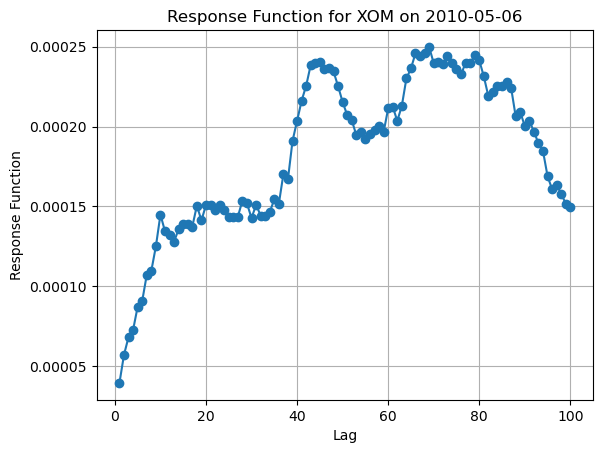

Checking path: SP500_2010_extracted/XOM_05/processed/2010-05-03-XOM-processed.csv
Found data for XOM on 2010-05-03


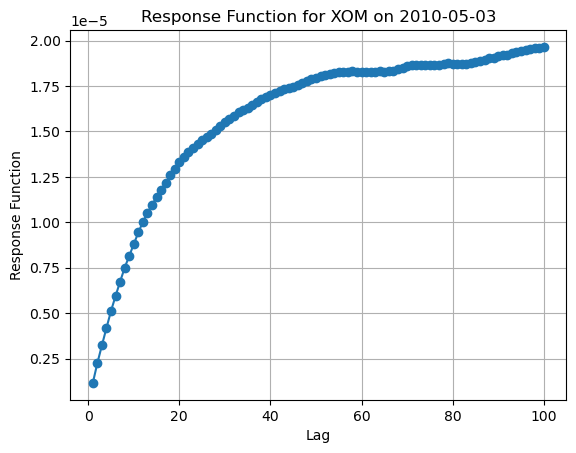

Checking path: SP500_2010_extracted/CTL_05/processed/2010-05-06-CTL-processed.csv
Found data for CTL on 2010-05-06


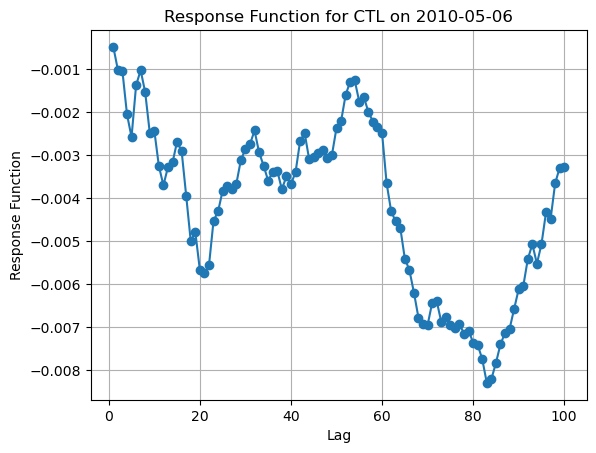

Checking path: SP500_2010_extracted/CTL_05/processed/2010-05-03-CTL-processed.csv
Found data for CTL on 2010-05-03


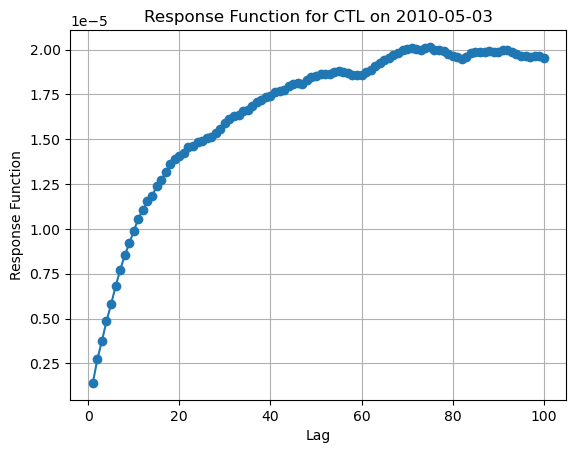

In [10]:


def compute_response_function(df, max_lag=100):
    """
    Compute the response function for given trade data.
    """
    df = df.with_columns(
        ((df["ask_price"] + df["bid_price"]) / 2).alias("mid_price")
    )
    df = df.with_columns(
        (df["trade_price"] - df["mid_price"].shift(1)).alias("trade_sign")
    )
    df = df.drop_nulls()
    
    signs = df["trade_sign"].to_numpy()
    mid_prices = df["mid_price"].to_numpy()
    
    response = np.array([
        np.mean(signs[:-lag] * (mid_prices[lag:] - mid_prices[:-lag]))
        if lag < len(signs) else np.nan for lag in range(1, max_lag + 1)
    ])
    return response

def plot_response_function(response, title):
    """
    Plot response function.
    """
    plt.plot(range(1, len(response) + 1), response, marker='o')
    plt.xlabel("Lag")
    plt.ylabel("Response Function")
    plt.title(title)
    plt.grid()
    plt.show()

if __name__ == "__main__":
    

    for ticker in TICKERS_OF_INTEREST:
        for day in [FLASH_CRASH_DATE, RANDOM_DAY]:
            subdir = f"{ticker}_05/processed"
            csv_path = os.path.join(BASE_DIR, subdir, f"{day}-{ticker}-processed.csv")
            print(f"Checking path: {csv_path}")
            if os.path.exists(csv_path):
                print(f"Found data for {ticker} on {day}")
                df = pl.read_csv(csv_path)
                response = compute_response_function(df)
                plot_response_function(response, f"Response Function for {ticker} on {day}")
            else:
                print(f"[WARN] Data not found for {ticker} on {day}")
